<h1>Simple MNIST Neural Network (2021)</h1>
<h3>This is an example of a simple neural network using Python 3 and numpy</h3>

In [132]:
import numpy as np
import pandas as pd
import zlib
import requests
import matplotlib.pyplot as plt
%matplotlib inline

<h2><b>Loader class</b>: load MNIST original dataset from a url</h2>

In [133]:
class MNISTLoader():
    def __init__(self, train_image, train_label, test_image, test_label):
        self.train_images = self.load_images(train_image)
        self.train_labels = self.load_labels(train_label)
        self.test_images  = self.load_images(test_image)
        self.test_labels  = self.load_labels(test_label)

    def load(self):
        return self.train_images, self.train_labels, self.test_images, self.test_labels
  
    # http://yann.lecun.com/exdb/mnist
    #
    # [offset] [type]          [value]          [description]
    # 0000     32 bit integer  0x00000803(2051) magic number
    # 0004     32 bit integer  60000            number of images
    # 0008     32 bit integer  28               number of rows
    # 0012     32 bit integer  28               number of columns
    # 0016     unsigned byte   ??               pixel
    # 0017     unsigned byte   ??               pixel
    # ........
    # xxxx     unsigned byte   ??               pixel
    # 
    # 1. starts from 16 (ignore first 15 bytes - header information)
    # 2. reshape to 784 columns, n rows
    # 3. transpose: we want 784 rows, n columns
    # 4. normalize by dividing by 255
    def load_images(self, dataset):
        return self.load_file(dataset)[16:].reshape((-1, 784)).T / 255

    # [offset] [type]          [value]          [description]
    # 0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    # 0004     32 bit integer  10000            number of items
    # 0008     unsigned byte   ??               label
    # 0009     unsigned byte   ??               label
    # ........
    # xxxx     unsigned byte   ??               label
    def load_labels(self, dataset):
        return self.load_file(dataset)[8:]  # starts from 8 ... n

    # Load from url and decompress
    def load_file(self, url):
        content = requests.get(url).content
        data = zlib.decompress(content, zlib.MAX_WBITS|32)
        return np.frombuffer(data, dtype = np.uint8)

<h2>Initialize helper methods</h2>

In [155]:
def sigmoid(Z):
  return 1.0 / (1.0 + np.exp(-Z))

def sigmoid_derivative(Z):
  s = self.sigmoid(Z)
  return s * (1 - s)

def relu(Z):
  return np.maximum(Z, 0)

def relu_derivative(Z):
  return (Z > 0).astype(int)

def softmax(Z):
  exp_Z = np.exp(Z)
  return exp_Z / sum(exp_Z)

def one_hot(Y):
  one_hot_Y = np.eye(10)[Y]
  return one_hot_Y.T.reshape(10, -1)

def plot_image(X, index):
  image = X[:, index].reshape(28, 28) 
  plt.gray()
  plt.imshow(image)
  plt.show()

<h2>Load test and training examples</h2>

In [135]:
train_images_url = 'https://raw.githubusercontent.com/rfdavid/simple-mnist-nn/master/dataset/train-images-idx3-ubyte.gz'
train_labels_url = 'https://raw.githubusercontent.com/rfdavid/simple-mnist-nn/master/dataset/train-labels-idx1-ubyte.gz'
test_images_url = 'https://raw.githubusercontent.com/rfdavid/simple-mnist-nn/master/dataset/t10k-images-idx3-ubyte.gz'
test_labels_url = 'https://raw.githubusercontent.com/rfdavid/simple-mnist-nn/master/dataset/t10k-labels-idx1-ubyte.gz'

dataset = MNISTLoader(train_images_url,train_labels_url, test_images_url, test_labels_url)
        
X_train, Y_train, X_test, Y_test = dataset.load()

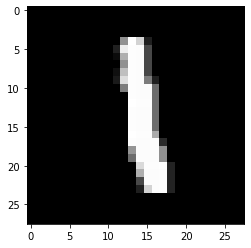

X_train shape:  (784, 60000)
Y_train shape:  (60000,)
X_test shape:  (784, 10000)
Y_test shape:  (10000,)


In [156]:
# Print some information

plot_image(X_train, 6)

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

<h2>Neural Network</h2>

<b>Initial setup</b>


*   1 input layer with 784 nodes/features
*   1 hidden layer with 128 nodes
*   1 output layer with 10 nodes

Initialize params (b and w) <b>></b> train loop <b>></b> feedforwad <b>></b> backward propagation <b>></b> update params

We are going to use simple methods without class so the variables are more explicit to understand from a mathematical point of view.




In [160]:
def initialize_params():
  # W1 size = 128x784 <-- number of nodes on input layer
  #             ^-------- number of nodes on the following (hidden) layer
  # multiply by 0.01 to prevent calc overflow
  # b1 size = hidden layer x 1
  W1 = np.random.rand(128, 784) * 0.01
  b1 = np.random.rand(128, 1)

  # W2 size = 10x128 <-- number of nodes on hidden layer
  #           ^--------- number of nodes on the following (output) layer
  # b2 size = output layer x 1
  W2 = np.random.rand(10, 128) * 0.01
  b2 = np.random.rand(10, 1)

  return W1, b1, W2, b2

In [161]:
# X (input) > Z1 / A1 (hidden layer) > Z2 / A2 (output layer) 
def feedforward(X, W1, b1, W2, b2):
  Z1 = W1.dot(X) + b1
  A1 = relu(Z1)
  Z2 = W2.dot(A1) + b2
  A2 = softmax(Z2)

  return Z1, A1, Z2, A2

In [162]:
# Calculate the derivative of W's and b's to update the params later
def backward_propagation(A2, Z2, A1, Z1, W2, W1, X, Y_one_hot, m):
  dZ2 = A2 - Y_one_hot
  dW2 = 1 / m * dZ2.dot(A1.T)
  db2 = 1 / m * np.sum(dZ2)
  dZ1 = W2.T.dot(dZ2) * relu_derivative(Z1)
  dW1 = 1 / m * dZ1.dot(X.T)
  db1 = 1 / m * np.sum(dZ1)
  
  return dW1, db1, dW2, db2


In [163]:
def update_params(W1, dW1, b1, db1, W2, dW2, b2, db2, learning_rate):
  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2

  return W1, b1, W2, b2

In [164]:
# Input: the calculated output layer (A2)
#         A2 shape = 10 x n
#         each row represents the probability to be 0 to 9
#
#         A2 example = [[0.0812547  0.07125533 0.07148461 ... 0.07139573 0.07139161 0.0714528 ]
#                      [0.12177335 0.12127117 0.12296045 ... 0.12265309 0.12290747 0.12275408]]
#  
#         which means for the first example/image, the highest probability is the first element (0.0812547)
#         therefore, the number is possibly 0
#
# Output: we want to convert this matrix to the same as the Y, so its easier to compare
#         Y shape = 60000 x 1
#         Y example = [2 0 3 9 1 1 ...]
#         
#         np.argmax returns the index of the maximum element. When using axis = 0, it will
#         flatten into an array of m x 1
#
#
def predictions(output):
  return np.argmax(output, axis = 0)

# get the output layer (A2) by feed forwarding using
# the params we already have: X training set, W1, W2, b1 and b2
def predict(X, W1, b1, W2, b2):
  _, _, _, A2 = feedforward(X, W1, b1, W2, b2)
  return predictions(A2)

# Sum when Y id equal predicted_Y (prediction was right)
# and divide by the total to get the % of accuracy
def accuracy(Y, predicted_Y):
  return np.sum(Y == predicted_Y) / Y.size


In [178]:
def train(X, Y, learning_rate, epochs):
  W1, b1, W2, b2 = initialize_params()
  m = X.shape[1]

  # Y_train = [ 1 4 3 9 0 1 ... ]
  # Y_one_hot = [ [0 1 0 0 0 0 0 0 0 0], [0 0 0 0 1 0 0 0 0 0] ... ]
  Y_one_hot = one_hot(Y)

  # gradient descent
  for i in range(epochs):
    Z1, A1, Z2, A2 = feedforward(X, W1, b1, W2, b2)
    dW1, db1, dW2, db2 = backward_propagation(A2, Z2, A1, Z1, W2, W1, X, Y_one_hot, m)
    W1, b1, W2, b2 = update_params(W1, dW1, b1, db1, W2, dW2, b2, db2, learning_rate)

    if i % 100 == 0:
      print("Iteration #", i)
      pred = predictions(A2)
      acc  = accuracy(Y, pred)
      print("Accuracy (training set): ",  "{:.2f}".format(acc * 100), "%")

  return W1, b1, W2, b2

In [179]:
W1, b1, W2, b2 = train(X_train, Y_train, learning_rate = 0.25, epochs = 1500)

Iteration # 0
Accuracy (training set):  9.86 %
Iteration # 100
Accuracy (training set):  86.37 %
Iteration # 200
Accuracy (training set):  90.14 %
Iteration # 300
Accuracy (training set):  91.13 %
Iteration # 400
Accuracy (training set):  91.84 %
Iteration # 500
Accuracy (training set):  92.46 %
Iteration # 600
Accuracy (training set):  92.98 %
Iteration # 700
Accuracy (training set):  93.48 %
Iteration # 800
Accuracy (training set):  93.92 %
Iteration # 900
Accuracy (training set):  94.34 %
Iteration # 1000
Accuracy (training set):  94.73 %
Iteration # 1100
Accuracy (training set):  95.01 %
Iteration # 1200
Accuracy (training set):  95.27 %
Iteration # 1300
Accuracy (training set):  95.53 %
Iteration # 1400
Accuracy (training set):  95.79 %


In [180]:
Y_predicted_test = predict(X_test, W1, b1, W2, b2)
acc = accuracy(Y_test, Y_predicted_test)

print("The accuracy on test dataset is: ", "{:.2f}".format(acc * 100), "%")

The accuracy on test dataset is:  95.71 %
